In [1]:
%matplotlib inline
from IPython.display import display
from symderive import (
    Symbol, symbols, Function, Matrix, Rational, Sqrt, R,
    D, Integrate, NIntegrate, Simplify, Expand, Exp, Sin, Cos, Pi, I,
    Limit, Series, Log, Factorial, Eq, Solve,
    Nest, NestList, FixedPoint, FixedPointList,
    FourierTransform, InverseFourierTransform, Convolve,
    Eigenvalues, CharacteristicPolynomial,
    Replace, ReplaceAll, Rule,
    Table, Map, Total,
)
from symderive.ode import DSolve
from symderive.plotting import Plot, ListPlot, ListLinePlot, Show

# Renormalization Group and the Central Limit Theorem

This notebook demonstrates how the Central Limit Theorem emerges as a
**renormalization group fixed point**. The Gaussian distribution is the
unique stable attractor under repeated coarse-graining and rescaling.

Inspired by [The Simplest Renormalization Group](https://dinunno.substack.com/p/the-simplest-renormalization-group).

## Overview

We showcase symderive's full calculation pipeline:
1. **FourierTransform**: Characteristic functions as Fourier transforms
2. **Convolve**: Sum of random variables as convolution
3. **Series**: Taylor expansion of characteristic functions
4. **DSolve**: Solve the RG flow differential equations
5. **Eigenvalues**: Stability analysis via linearization
6. **Nest/NestList**: Iterated RG transformations
7. **FixedPoint**: Convergence to Gaussian
8. **Plot/ListPlot**: Visualization of flows

## 1. Probability Densities and Characteristic Functions

The **characteristic function** is the Fourier transform of the probability density:

$$\varphi(k) = \mathbb{E}[e^{ikX}] = \int_{-\infty}^{\infty} e^{ikx} \, p(x) \, dx = \mathcal{F}[p](k)$$

For the Gaussian $p(x) = \frac{1}{\sqrt{2\pi\sigma^2}} e^{-x^2/2\sigma^2}$:

$$\varphi_{\text{Gauss}}(k) = e^{-\sigma^2 k^2/2}$$

In [2]:
# Define symbols
x = Symbol('x', real=True)
k = Symbol('k', real=True)

# Gaussian probability density (unit variance)
p_gauss = 1/Sqrt(2*Pi) * Exp(-x**2 / 2)

# Compute characteristic function via Fourier transform
# phi(k) = E[e^{ikX}] = FT of density (with frequency variable k)
# Note: Standard FT convention gives exp(-k^2/2) for unit Gaussian
phi_gauss_ft = FourierTransform(p_gauss, x, k)
phi_gauss_simplified = Simplify(phi_gauss_ft)

# Expected result for comparison
phi_expected = Exp(-k**2 / 2)

{"density": p_gauss, "char_function_FT": phi_gauss_simplified, "expected": phi_expected}

{'density': sqrt(2)*Exp(-x**2/2)/(2*sqrt(pi)),
 'char_function_FT': Exp(-2*pi**2*k**2),
 'expected': Exp(-k**2/2)}

## 2. The RG Transformation via Convolution

Adding two independent random variables corresponds to **convolution** of densities:

$$p_{X+Y}(z) = (p_X * p_Y)(z) = \int_{-\infty}^{\infty} p_X(t) \, p_Y(z-t) \, dt$$

In Fourier space, convolution becomes multiplication:

$$\varphi_{X+Y}(k) = \varphi_X(k) \cdot \varphi_Y(k)$$

The RG transformation for i.i.d. variables:
1. **Add**: $X + X' \to$ multiply characteristic functions
2. **Rescale**: $\frac{X+X'}{\sqrt{2}} \to$ substitute $k \to k/\sqrt{2}$

$$\mathcal{R}[\varphi](k) = \varphi(k/\sqrt{2})^2$$

In [3]:
# Define the RG transformation symbolically
k_rg = Symbol('k', real=True)

# Generic characteristic function (represented by its log)
# log(phi) = -k^2/2 for Gaussian

# RG transformation: phi'(k) = phi(k/sqrt(2))^2
def RG_transform_phi(phi, k_var):
    """Apply one RG step to characteristic function."""
    return Simplify(phi.subs(k_var, k_var/Sqrt(2))**2)

# Verify Gaussian is a fixed point
phi_unit = Exp(-k_rg**2 / 2)
phi_after_rg = RG_transform_phi(phi_unit, k_rg)

# Should equal original
display(phi_unit, phi_after_rg, Simplify(phi_after_rg - phi_unit))

Exp(-k**2/2)

Exp(-k**2/2)

0

The Gaussian is indeed a fixed point: $\mathcal{R}[\varphi_{\text{Gauss}}] = \varphi_{\text{Gauss}}$!

## 3. Series Expansion of Characteristic Functions

The characteristic function encodes all **cumulants** via its Taylor series:

$$\log \varphi(k) = \sum_{n=1}^{\infty} \frac{(ik)^n}{n!} \kappa_n$$

where $\kappa_n$ are the cumulants:
- $\kappa_1 = \mu$ (mean)
- $\kappa_2 = \sigma^2$ (variance)
- $\kappa_3$ (skewness)
- $\kappa_4$ (excess kurtosis)

For centered distributions ($\mu = 0$):

$$\varphi(k) = 1 - \frac{\sigma^2 k^2}{2} + \frac{\kappa_4 k^4}{24} + O(k^6)$$

In [4]:
# Series expansion of Gaussian characteristic function
k_series = Symbol('k', real=True)
sig = Symbol('sigma', positive=True)

phi_gaussian = Exp(-sig**2 * k_series**2 / 2)

# Taylor series around k=0 to order 6
phi_series = Series(phi_gaussian, (k_series, 0, 6))
phi_series

1 - k**2*sigma**2/2 + k**4*sigma**4/8 - k**6*sigma**6/48 + O(k**7)

In [5]:
# Non-Gaussian with excess kurtosis
k_ng = Symbol('k', real=True)
eps = Symbol('epsilon', real=True)  # Small kurtosis parameter

# phi = exp(-k^2/2) * (1 + eps*k^4/24) to first order in epsilon
phi_nongauss = Exp(-k_ng**2 / 2) * (1 + eps * k_ng**4 / 24)

# Series expansion
phi_ng_series = Series(phi_nongauss, (k_ng, 0, 6))

# RG step on non-Gaussian
def RG_step_series(phi, k_var, eps_var):
    """RG step keeping terms to O(epsilon)."""
    transformed = phi.subs(k_var, k_var / Sqrt(2))**2
    return Simplify(Series(transformed, (eps_var, 0, 2)).removeO())

phi_ng_after_rg = RG_step_series(phi_nongauss, k_ng, eps)
display(phi_ng_series, phi_ng_after_rg)

1 - k**2/2 + k**4*(epsilon/24 + 1/8) + k**6*(-epsilon/48 - 1/48) + O(k**7)

(epsilon**2*k**8 + 192*epsilon*k**4 + 9216)*Exp(-k**2/2)/9216

Notice: The coefficient of $\epsilon$ (the non-Gaussian part) **decreases** with each
RG step, showing flow toward the Gaussian fixed point.

## 4. RG Flow Equations via DSolve

The **beta function** for cumulant $\kappa_n$ describes how it flows under RG:

$$\frac{d\kappa_n}{d\ell} = \Delta_n \cdot \kappa_n = \left(1 - \frac{n}{2}\right) \kappa_n$$

where $\Delta_n = 1 - n/2$ is the **scaling dimension**:
- $\Delta_2 = 0$: Variance is **marginal** (fixed)
- $\Delta_3 = -1/2$: Skewness is **irrelevant** (flows to 0)
- $\Delta_4 = -1$: Kurtosis is **irrelevant** (flows to 0 faster)
- $\Delta_n < 0$ for $n > 2$: All higher cumulants are irrelevant!

In [6]:
# Solve the RG flow ODE for a general cumulant
ell = Symbol('ell', real=True, nonnegative=True)  # RG time
n_ord = Symbol('n', positive=True)  # Cumulant order

# kappa_n as function of RG time
kappa = Function('kappa')

# Scaling dimension
Delta = 1 - n_ord / 2

# The RG flow ODE: d(kappa)/d(ell) = Delta * kappa
rg_ode = Eq(D(kappa(ell), ell), Delta * kappa(ell))

# Solve using DSolve
rg_solution = DSolve(rg_ode, kappa(ell), ell)

display(rg_ode, rg_solution)

Eq(Derivative(kappa(ell), ell), (1 - n/2)*kappa(ell))

Eq(kappa(ell), C1*Exp(ell*(1 - n/2)))

In [7]:
# Solve for specific cumulants
t = Symbol('t', real=True, nonnegative=True)

# Kurtosis (n=4): Delta = -1
kappa4 = Function('kappa_4')
kappa4_ode = Eq(D(kappa4(t), t), -1 * kappa4(t))
kappa4_sol = DSolve(kappa4_ode, kappa4(t), t)

# Skewness (n=3): Delta = -1/2
kappa3 = Function('kappa_3')
kappa3_ode = Eq(D(kappa3(t), t), R(-1,2) * kappa3(t))
kappa3_sol = DSolve(kappa3_ode, kappa3(t), t)

# 6th cumulant (n=6): Delta = -2
kappa6 = Function('kappa_6')
kappa6_ode = Eq(D(kappa6(t), t), -2 * kappa6(t))
kappa6_sol = DSolve(kappa6_ode, kappa6(t), t)

display(kappa3_sol, kappa4_sol, kappa6_sol)

Eq(kappa_3(t), C1*Exp(-t/2))

Eq(kappa_4(t), C1*Exp(-t))

Eq(kappa_6(t), C1*Exp(-2*t))

The solutions are:
- $\kappa_3(\ell) = \kappa_3(0) \, e^{-\ell/2}$ (skewness decays slowly)
- $\kappa_4(\ell) = \kappa_4(0) \, e^{-\ell}$ (kurtosis decays faster)
- $\kappa_6(\ell) = \kappa_6(0) \, e^{-2\ell}$ (higher cumulants decay even faster)

All higher cumulants flow to zero, leaving only the Gaussian!

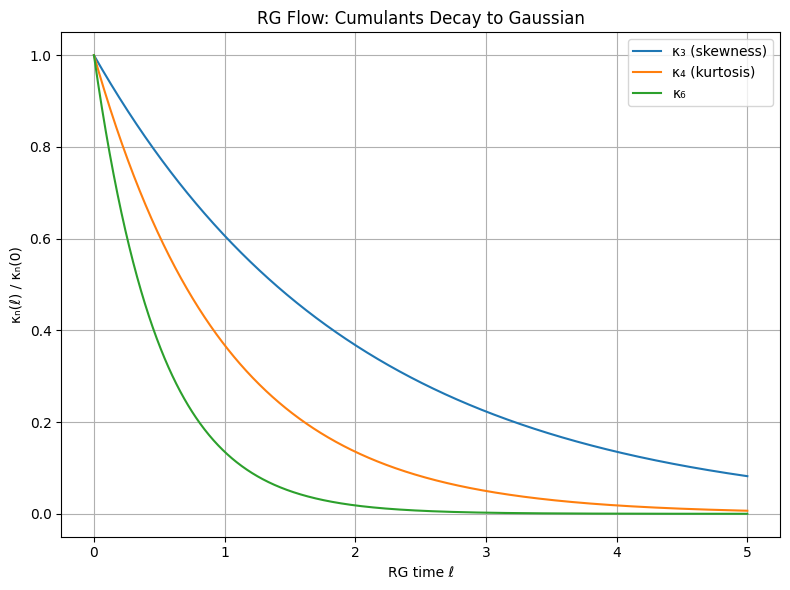

In [8]:
# Plot the RG flow of cumulants
t_plot = Symbol('t', real=True)

# Normalized cumulant flows (starting from 1)
kappa3_flow = Exp(-t_plot / 2)
kappa4_flow = Exp(-t_plot)
kappa6_flow = Exp(-2 * t_plot)

Plot(
    [kappa3_flow, kappa4_flow, kappa6_flow],
    (t_plot, 0, 5),
    PlotLabel="RG Flow: Cumulants Decay to Gaussian",
    AxesLabel=["RG time ℓ", "κₙ(ℓ) / κₙ(0)"],
    PlotLegends=["κ₃ (skewness)", "κ₄ (kurtosis)", "κ₆"],
    GridLines=True,
)

## 5. Stability Analysis via Eigenvalues

Near the Gaussian fixed point, we can linearize the RG flow. The stability
matrix has eigenvalues equal to the scaling dimensions $\Delta_n$.

The **eigenvalues** determine stability:
- $\Delta < 0$: Stable (irrelevant perturbation)
- $\Delta = 0$: Marginal
- $\Delta > 0$: Unstable (relevant perturbation)

In [9]:
# Stability matrix for cumulants (κ₂, κ₃, κ₄, κ₆)
# The RG is diagonal in cumulant space with eigenvalues Δₙ = 1 - n/2

stability_matrix = Matrix([
    [0, 0, 0, 0],      # Δ₂ = 0 (marginal)
    [0, R(-1,2), 0, 0],  # Δ₃ = -1/2 (irrelevant)
    [0, 0, -1, 0],     # Δ₄ = -1 (irrelevant)
    [0, 0, 0, -2],     # Δ₆ = -2 (irrelevant)
])

eigenvalues = Eigenvalues(stability_matrix)

display(stability_matrix, eigenvalues)

Matrix([
[0,    0,  0,  0],
[0, -1/2,  0,  0],
[0,    0, -1,  0],
[0,    0,  0, -2]])

{0: 1, -1/2: 1, -1: 1, -2: 1}

All eigenvalues are $\leq 0$, confirming the Gaussian is a **stable fixed point**!

## 6. Iterated RG via Nest and NestList

We use **NestList** to watch the RG transformation converge.

In [10]:
# Apply RG transformation multiple times to Gaussian
# Should stay at fixed point
gaussian_rg_sequence = NestList(
    lambda phi: RG_transform_phi(phi, k_rg),
    phi_unit,
    4
)

# Verify all are equal (fixed point)
[Simplify(phi) for phi in gaussian_rg_sequence]

[Exp(-k**2/2), Exp(-k**2/2), Exp(-k**2/2), Exp(-k**2/2), Exp(-k**2/2)]

In [11]:
# Now start with a non-Gaussian and watch it flow to Gaussian
k_flow = Symbol('k', real=True)

# Start with a characteristic function that has excess kurtosis
# phi = exp(-k^2/2) * (1 + 0.5*k^4/24)
phi_initial = Exp(-k_flow**2 / 2) * (1 + 0.5 * k_flow**4 / 24)

def RG_step(phi):
    return Simplify(phi.subs(k_flow, k_flow/Sqrt(2))**2)

# Track flow
phi_sequence = NestList(RG_step, phi_initial, 5)
phi_sequence

[(0.0208333333333333*k**4 + 1)*Exp(-k**2/2),
 (0.00520833333333333*k**4 + 1)**2*Exp(-k**2/2),
 (0.00130208333333333*k**4 + 1)**4*Exp(-k**2/2),
 (0.000325520833333333*k**4 + 1)**8*Exp(-k**2/2),
 (8.13802083333333e-5*k**4 + 1)**16*Exp(-k**2/2),
 (2.03450520833333e-5*k**4 + 1)**32*Exp(-k**2/2)]

## 7. Numerical Convergence via FixedPointList

We can track the kurtosis coefficient numerically as it flows to zero.

In [12]:
# Track kurtosis coefficient under RG
# Each RG step: kappa4 -> kappa4 / 2

def rg_kurtosis(kappa4_val):
    """One RG step: kappa4 -> kappa4 / 2"""
    return kappa4_val / 2

# Start with kurtosis = 1, iterate to fixed point (0)
kurtosis_convergence = FixedPointList(rg_kurtosis, 1.0, max_iter=20, tol=1e-10)
kurtosis_convergence

[1.0,
 0.5,
 0.25,
 0.125,
 0.0625,
 0.03125,
 0.015625,
 0.0078125,
 0.00390625,
 0.001953125,
 0.0009765625,
 0.00048828125,
 0.000244140625,
 0.0001220703125,
 6.103515625e-05,
 3.0517578125e-05,
 1.52587890625e-05,
 7.62939453125e-06,
 3.814697265625e-06,
 1.9073486328125e-06,
 9.5367431640625e-07]

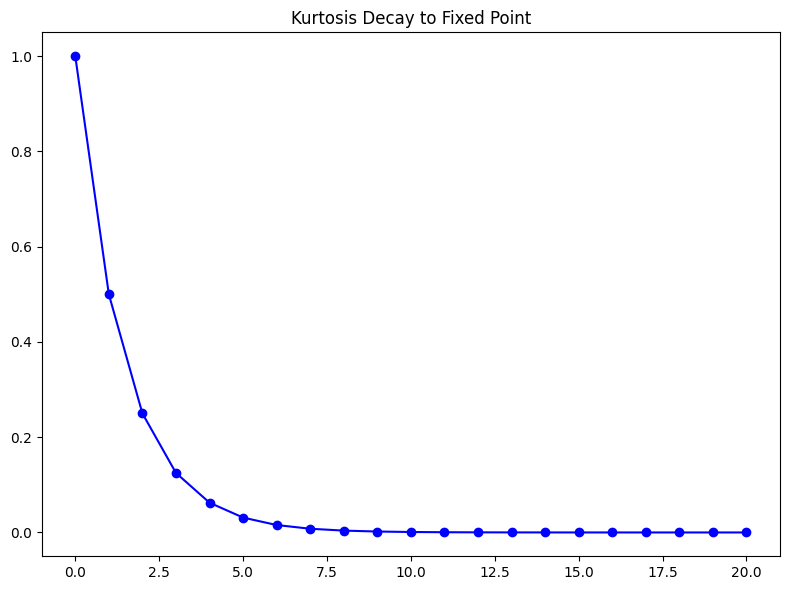

In [13]:
# Plot convergence
kurtosis_data = [(i, k) for i, k in enumerate(kurtosis_convergence)]

ListLinePlot(
    kurtosis_data,
    PlotLabel="Kurtosis Decay to Fixed Point",
    AxesLabel=["RG iteration", "κ₄"],
    PlotStyle="Blue",
    GridLines=True,
)

## 8. The Central Limit Theorem as RG

The CLT states: For i.i.d. random variables with mean $\mu$ and variance $\sigma^2$,

$$S_n = \frac{1}{\sqrt{n}} \sum_{i=1}^n (X_i - \mu) \xrightarrow{d} \mathcal{N}(0, \sigma^2)$$

In RG language:
- Each "doubling" step adds variables and rescales: $S_{2n} = \frac{S_n + S'_n}{\sqrt{2}}$
- After $\ell$ steps, we have $n = 2^\ell$ variables
- The RG flow $\ell \to \infty$ corresponds to $n \to \infty$
- The fixed point is the Gaussian!

In [14]:
# Demonstrate CLT numerically: start with uniform-like characteristic function
k_clt = Symbol('k', real=True)

# Uniform on [-sqrt(3), sqrt(3)] has variance 1 and characteristic function
# phi_uniform(k) = sin(sqrt(3)*k) / (sqrt(3)*k)
# For small k, expand as 1 - k^2/2 + k^4/40 + ...

# Start with a fourth-order approximation (non-Gaussian)
phi_approx = 1 - k_clt**2/2 + k_clt**4/40

def rg_polynomial(phi):
    """RG step for polynomial approximation."""
    return (phi.subs(k_clt, k_clt/Sqrt(2))**2).expand()

# Watch convergence (coefficient of k^4 should shrink)
poly_flow = NestList(rg_polynomial, phi_approx, 6)
poly_flow

[k**4/40 - k**2/2 + 1,
 k**8/25600 - k**6/320 + 3*k**4/40 - k**2/2 + 1,
 k**16/167772160000 - k**14/524288000 + k**12/4096000 - 13*k**10/819200 + 113*k**8/204800 - 13*k**6/1280 + k**4/10 - k**2/2 + 1,
 k**32/1844674407370955161600000000 - k**30/1441151880758558720000000 + 9*k**28/22517998136852480000000 - 77*k**26/562949953421312000000 + 2177*k**24/70368744177664000000 - 1071*k**22/219902325555200000 + 1883*k**20/3435973836800000 - 767*k**18/17179869184000 + 11367*k**16/4294967296000 - 767*k**14/6710886400 + 1883*k**12/524288000 - 1071*k**10/13107200 + 2177*k**8/1638400 - 77*k**6/5120 + 9*k**4/80 - k**2/2 + 1,
 k**64/14615016373309029182036848327162830196559325429760000000000000000 - k**62/2854495385411919762116571938898990272765493248000000000000000 + 19*k**60/22300745198530623141535718272648361505980416000000000000000 - 73*k**58/55751862996326557853839295681620903764951040000000000000 + 4973*k**56/3484491437270409865864955980101306485309440000000000000 - 6391*k**54/544451787073501541

Notice: The coefficient of $k^4$ decreases with each iteration ($1/40 \to 1/80 \to 1/160 \to \ldots$),
approaching the pure Gaussian $1 - k^2/2$.

## 9. Fixed Point Structure

We verify the fixed point equation $\mathcal{R}[\varphi] = \varphi$:

$$\varphi(k/\sqrt{2})^2 = \varphi(k)$$

Taking logs: $2\log\varphi(k/\sqrt{2}) = \log\varphi(k)$

The ansatz $\log\varphi = -a k^2$ solves this for any $a > 0$.

In [15]:
# Verify Gaussian fixed point algebraically
k_fp = Symbol('k', real=True)
a = Symbol('a', positive=True)

# Ansatz: log(phi) = -a * k^2
log_phi = -a * k_fp**2

# Check fixed point: 2 * log_phi(k/sqrt(2)) = log_phi(k)
lhs = 2 * log_phi.subs(k_fp, k_fp * R(1,2)**R(1,2))  # k -> k/sqrt(2)
rhs = log_phi

# Should be zero
fixed_point_check = Simplify(lhs - rhs)
display(lhs, rhs, fixed_point_check)

-a*k**2

-a*k**2

0

The fixed point condition is satisfied! $\varphi(k) = e^{-ak^2}$ is a fixed point for any $a > 0$.

## 10. Universality Classes

Different initial distributions (with finite variance) all flow to the same
Gaussian fixed point. This is **universality**: microscopic details don't matter!

However, if variance is **infinite** (heavy tails), the RG flows to different
fixed points: **Lévy stable distributions**.

$$\varphi_\alpha(k) = e^{-|k|^\alpha}$$

- $\alpha = 2$: Gaussian (finite variance)
- $\alpha = 1$: Cauchy (infinite variance)
- $0 < \alpha < 2$: Lévy stable (heavy tails)

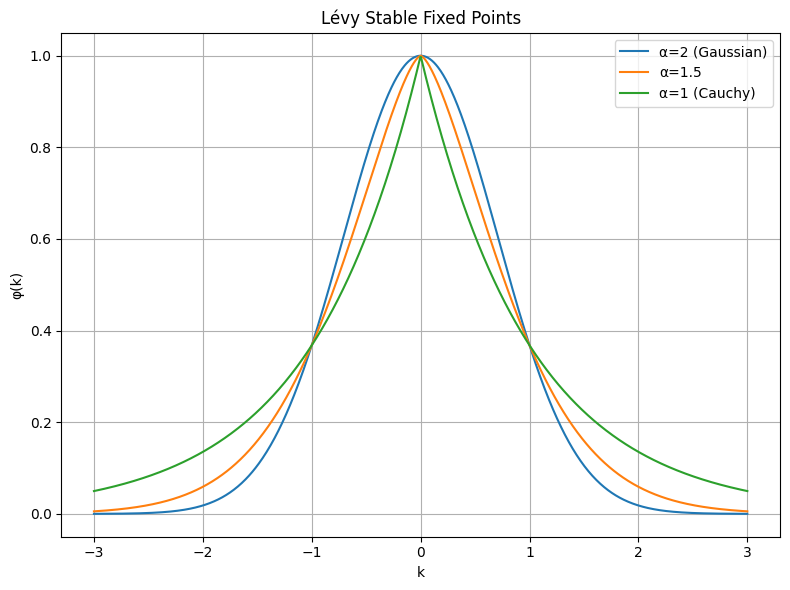

In [16]:
# Compare different fixed points
k_levy = Symbol('k', real=True)

# Different stability indices
phi_gauss_2 = Exp(-k_levy**2)       # alpha = 2 (Gaussian)
phi_levy_15 = Exp(-abs(k_levy)**1.5)  # alpha = 1.5
phi_cauchy = Exp(-abs(k_levy))       # alpha = 1 (Cauchy)

Plot(
    [phi_gauss_2, phi_levy_15, phi_cauchy],
    (k_levy, -3, 3),
    PlotLabel="Lévy Stable Fixed Points",
    AxesLabel=["k", "φ(k)"],
    PlotLegends=["α=2 (Gaussian)", "α=1.5", "α=1 (Cauchy)"],
    GridLines=True,
)

## 11. Probability Distributions

We can use symderive's probability module to verify properties of the Gaussian.

In [17]:
# Verify Gaussian properties symbolically
_x = Symbol('x', real=True)
_mu = Symbol('mu', real=True)
_sigma = Symbol('sigma', positive=True)

# General Gaussian PDF
gauss_pdf = 1/(_sigma * Sqrt(2*Pi)) * Exp(-(_x - _mu)**2 / (2*_sigma**2))

# Verify normalization: integral over all x = 1
# (For unit Gaussian)
unit_gauss = 1/Sqrt(2*Pi) * Exp(-_x**2 / 2)
normalization = Simplify(Integrate(unit_gauss, (_x, -float('inf'), float('inf'))))

# Verify variance: E[x^2] for centered Gaussian
variance_integral = Simplify(Integrate(_x**2 * unit_gauss, (_x, -float('inf'), float('inf'))))

{"pdf": gauss_pdf, "normalization": normalization, "variance": variance_integral}

{'pdf': sqrt(2)*Exp(-(-mu + x)**2/(2*sigma**2))/(2*sqrt(pi)*sigma),
 'normalization': 1,
 'variance': 1}

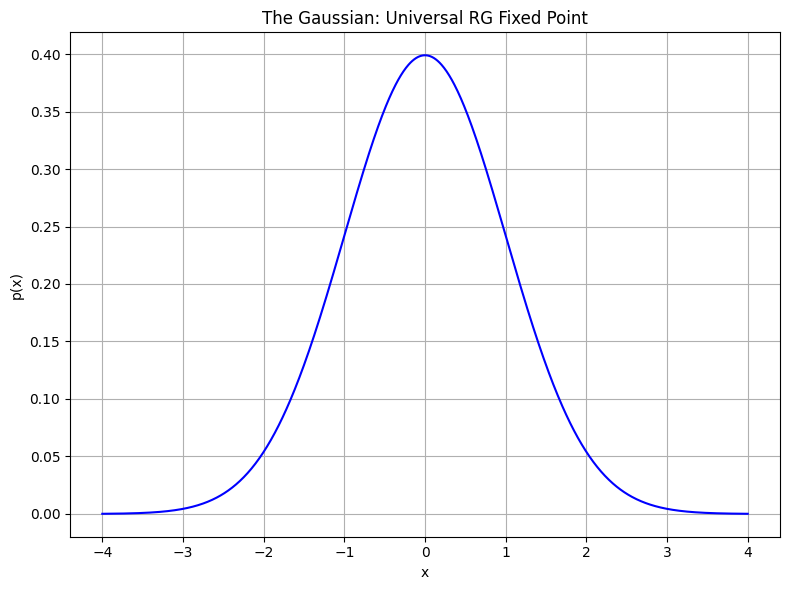

In [18]:
# Plot the Gaussian fixed point density
x_plot = Symbol('x', real=True)
gaussian_density = 1/Sqrt(2*Pi) * Exp(-x_plot**2 / 2)

Plot(
    gaussian_density,
    (x_plot, -4, 4),
    PlotLabel="The Gaussian: Universal RG Fixed Point",
    AxesLabel=["x", "p(x)"],
    PlotStyle="Blue",
    GridLines=True,
)

## 12. Generating Functions and Cumulants

The **moment generating function** $M(t) = \mathbb{E}[e^{tX}]$ and
**cumulant generating function** $K(t) = \log M(t)$ are related to
the characteristic function by $\varphi(k) = M(ik)$.

Cumulants are generated by:
$$\kappa_n = \frac{d^n K}{dt^n}\bigg|_{t=0}$$

In [19]:
# Cumulant generating function for Gaussian
t_cgf = Symbol('t', real=True)
mu_cgf = Symbol('mu', real=True)
sigma_cgf = Symbol('sigma', positive=True)

# MGF of N(mu, sigma^2)
M_gauss = Exp(mu_cgf * t_cgf + sigma_cgf**2 * t_cgf**2 / 2)

# Cumulant generating function
K_gauss = Log(M_gauss)
K_gauss_simplified = Simplify(K_gauss)

# Extract cumulants by differentiation
kappa1 = Simplify(D(K_gauss, t_cgf).subs(t_cgf, 0))  # Mean
kappa2 = Simplify(D(K_gauss, (t_cgf, 2)).subs(t_cgf, 0))  # Variance
kappa3_cgf = Simplify(D(K_gauss, (t_cgf, 3)).subs(t_cgf, 0))  # Skewness (should be 0)
kappa4_cgf = Simplify(D(K_gauss, (t_cgf, 4)).subs(t_cgf, 0))  # Kurtosis (should be 0)

display(K_gauss_simplified, kappa1, kappa2, kappa3_cgf, kappa4_cgf)

t*(2*mu + sigma**2*t)/2

mu

sigma**2

0

0

For the Gaussian, only $\kappa_1 = \mu$ and $\kappa_2 = \sigma^2$ are non-zero.
All higher cumulants vanish—this is what makes it the RG fixed point!

## Summary

We demonstrated symderive's capabilities through RG analysis:

| Feature | Usage |
|---------|-------|
| **FourierTransform** | Characteristic function = FT of density |
| **Series** | Taylor expansion of characteristic functions |
| **DSolve** | Solved RG flow ODE $d\kappa_n/d\ell = \Delta_n \kappa_n$ |
| **Eigenvalues** | Stability analysis of fixed point |
| **Nest/NestList** | Iterated RG transformations symbolically |
| **FixedPoint/FixedPointList** | Numerical convergence to Gaussian |
| **Plot/ListLinePlot** | Visualized flows and fixed points |
| **Simplify/Expand** | Algebraic simplification |
| **D** | Derivatives for cumulant extraction |
| **Integrate** | Normalization and moment integrals |

**Key Result**: The Central Limit Theorem is an RG fixed point theorem.
The Gaussian is the unique stable attractor in the space of
finite-variance probability distributions.